In [285]:
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn.model_selection import TimeSeriesSplit


<Axes: xlabel='Date'>

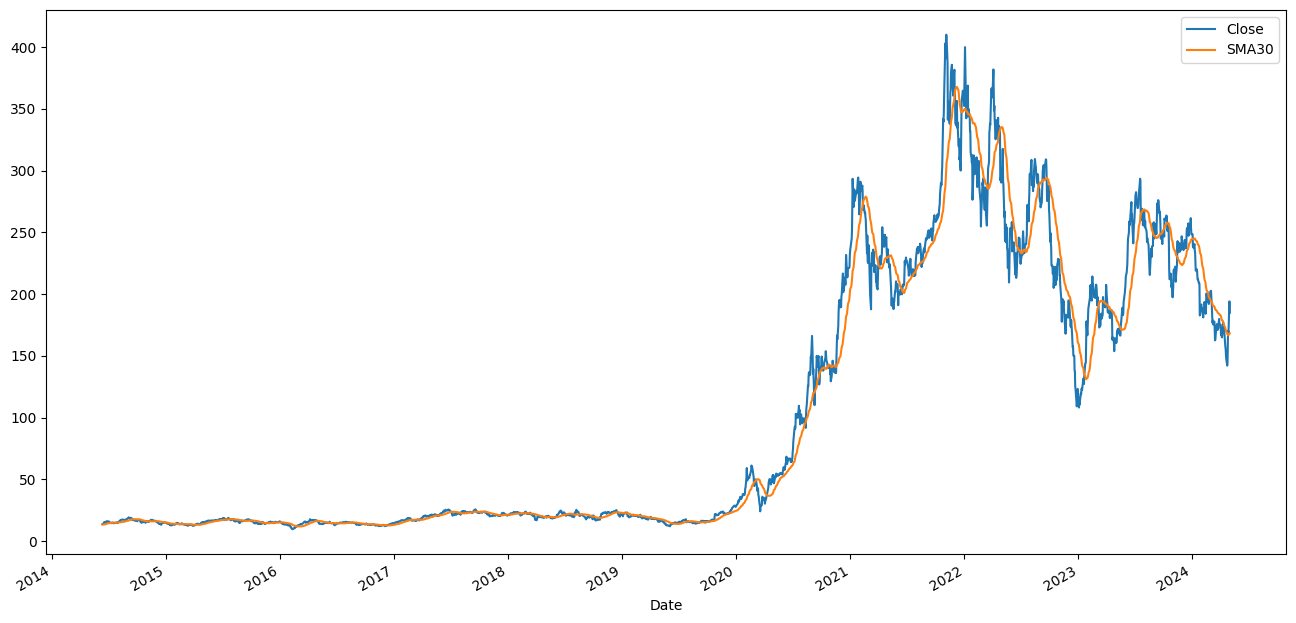

In [286]:
msft = yf.Ticker("TSLA")

hist = msft.history(period="10y")

hist = hist.drop(columns=["Open", "High", "Low","Stock Splits", "Dividends"])

# Calculate 30-day Simple Moving Average (SMA)
hist['SMA30'] = hist['Close'].rolling(30).mean()
 
# Remove NULL values
hist.dropna(inplace=True)

hist.head()
#plot = plt.plot(hist["Close"])
hist[['Close', 'SMA30']].plot(figsize=(16, 8))


## Dividing data into training and test

In [287]:
ts_cv = TimeSeriesSplit(
    n_splits=10,  # to keep the notebook fast enough on common laptops
    gap=48  # 2 days data gap between train and test  # for 2 or 3 digits of precision in scores
)
all_splits = list(ts_cv.split(hist, hist["Close"] ))
train_idx, test_idx = all_splits[0]
X_train, X_test = hist.iloc[train_idx], hist.iloc[test_idx]
y_train, y_test = hist["Close"].iloc[train_idx], hist["Close"].iloc[test_idx]

print(X_train)


                               Close     Volume      SMA30
Date                                                      
2014-06-11 00:00:00-04:00  13.631333   59662500  13.426289
2014-06-12 00:00:00-04:00  13.568000   89905500  13.416578
2014-06-13 00:00:00-04:00  13.761333   53164500  13.413667
2014-06-16 00:00:00-04:00  14.974000  198696000  13.444111
2014-06-17 00:00:00-04:00  15.444667  199573500  13.477578
...                              ...        ...        ...
2015-02-23 00:00:00-05:00  13.822667  127497000  13.749445
2015-02-24 00:00:00-05:00  13.607333   99054000  13.743778
2015-02-25 00:00:00-05:00  13.584000   58642500  13.747222
2015-02-26 00:00:00-05:00  13.812667   97093500  13.753756
2015-02-27 00:00:00-05:00  13.556000   58231500  13.777422

[181 rows x 3 columns]


In [288]:
#train on first 9 years, predict the last

X_train = hist[:2250]
X_test = hist[2250:2518]

y_train = hist["Close"][:2250]
y_test = hist["Close"][2250:2518]

#Uncomment for 30 days of predictions
#X_test = hist[2250:2280]
#y_test = hist["Close"][2250:2280]

## Recuring Nueral Network - Long short term memory layers
Sequential - linear layers.  
Dense: standard NN layer
LSTM:layer used for time series data
Dropout: randomly ignore neurons to avoid overfitting

In [289]:

model = keras.models.Sequential() 
model.add(keras.layers.LSTM(units=64, 
                            return_sequences=True, 
                            input_shape=(X_train.shape[1], 1))) 
model.add(keras.layers.LSTM(units=64)) 
model.add(keras.layers.Dense(32)) 
model.add(keras.layers.Dropout(0.5)) 
model.add(keras.layers.Dense(1)) 
model.summary 

/Users/natebowers/Documents/ATCS/TradingML/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<bound method Model.summary of <Sequential name=sequential_35, built=True>>

In [290]:
model.compile(optimizer='adam', 
              loss='mean_squared_error') 
history = model.fit(X_train, 
                    y_train, 
                    epochs=20)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 17182.5371
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9533.5186
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3657.2266
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1513.7734
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1133.0170
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1052.9427
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 892.0899
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 749.6748
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 748.0995
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 704.5717
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 810.4565
Epoch 12/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 821.7877
Epoch 13/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 691.9826
Epoch 14/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 659.3807
Epoch 15/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

## Making Predictions

In [291]:
# predict the testing data 
predictions = model.predict(X_test) 
#predictions = scaler.inverse_transform(predictions) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


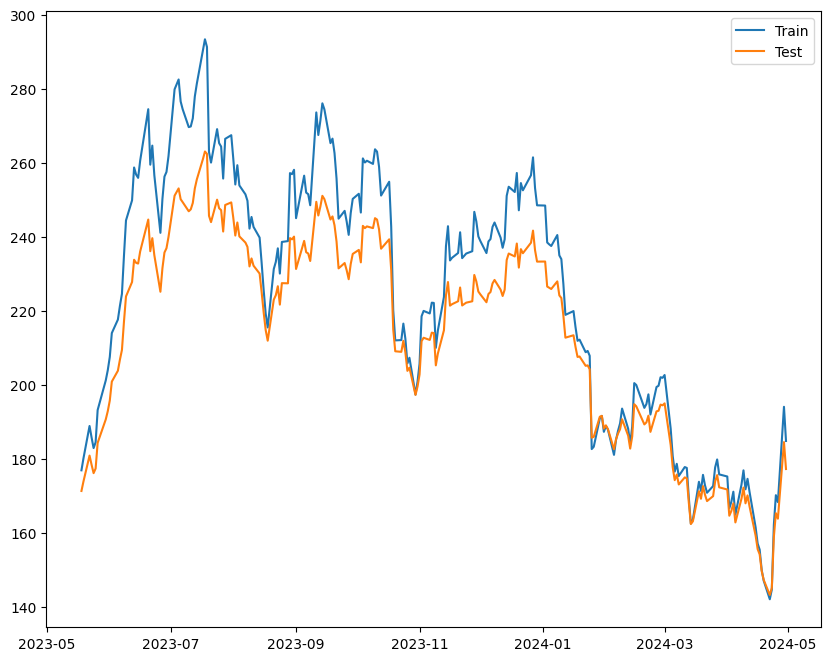

In [292]:
  
plt.figure(figsize=(10, 8)) 
#plt.plot(X_train.index, y_train) 
plt.plot(X_test.index, y_test) 
plt.plot(X_test.index, predictions) 
plt.legend(['Train', 'Test', 'Predictions']) 

